# Step 4: Applying the MaxEnt Model 🚀

The goal of this step is to **train and apply a MaxEnt model** to predict the **probability of presence of Zosteraceae** based on the environmental variables. MaxEnt is a **maximum-entropy classifier** (similar to multinomial logistic regression) commonly used in species distribution modeling.

For reference, you can check these resources:  
- [Elapid documentation](https://earth-chris.github.io/elapid/sdm/maxent/)  
- [MaxEnt Open Source](https://biodiversityinformatics.amnh.org/open_source/maxent/)  
- [Elapid PyPI](https://pypi.org/project/elapid/0.1.0/)

#### 📚 Required Libraries
To train and apply the MaxEnt model, the following libraries are required:

- **`pandas`**: For reading, manipulating, and analyzing tabular data.  
- **`elapid`**: To fit and apply the MaxEnt model.  
- **`sklearn`**: For additional machine learning tools used by MaxEnt.  
- **`geopandas`**: For handling spatial data.  
- **`shapely`**: To convert geometries into proper `POLYGON` objects for spatial operations.

### 🛠️ Steps:
1. **Train the Model**:  
   - Fit the MaxEnt model using the **formatted dataset** containing Zosteraceae observations and environmental predictors.

2. **Apply the Model and Generate Predictions**:  
   - Use the trained model to **predict the probability of presence** across the 250m x 250m grid.  
   - Visualize the results as a **spatial map** to identify suitable habitats.

3. **Evaluate and Comment on the Results**:  
   - Assess model outputs and identify areas for **improvement**, such as adding variables, adjusting the grid resolution, or addressing collinearity.  



_____



In [26]:
import elapid
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

### 🏋🏼 Train the Model

In [27]:
# Load the nput data
df_inputs_variables = pd.read_csv("data/03_inputs_environmental_variables.csv")
df_inputs_variables.columns

Index(['mean_bathymetry', 'chl', 'no3', 'ph', 'po4', 'siconc', 'sob', 'thetao',
       'uo', 'vo', 'VTM01_SW2', 'VSDX', 'geometry', 'presence'],
      dtype='object')

To use the MaxEnt model, I need to define the predictors (`x`) and the presence (`y`) column.

In [28]:
# Create the ndarray of environmental covariates of shape (n_samples, n_covariates)
predictor_cols = ['mean_bathymetry', 'chl', 'no3', 'ph', 'po4', 'siconc', 'sob', 'thetao','uo', 'vo', 'VTM01_SW2', 'VSDX']
X = df_inputs_variables[predictor_cols].values.astype(float)
# Create the ndarray or series of species presence/background labels (rows labeled 1 or 0)
y = df_inputs_variables["presence"].values.astype(int)

I spit the datas between the train and the test.

In [29]:
# Train / test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

I define and fit the model using the training data.

In [30]:
# Instantiate a MaxEnt model
model = elapid.MaxentModel(
    feature_types=["linear", "quadratic", "hinge"],   # common MaxEnt defaults
    beta_multiplier=1.0,    # ↑ = more regularisation, ↓ = looser fit
    clamp=True,             # prevents crazy extrapolation outside env. range
    n_cpus=4                # parallel cores; set to 1 if you prefer serial
)

In [31]:
# Fit the model
model.fit(X_tr, y_tr)

MaxentModel(beta_multiplier=1.0, feature_types=['linear', 'quadratic', 'hinge'],
            n_cpus=4)

### 🚀 Apply the Model and Plot the results

I use the test data to evaluate the model's performance. I used the ROC AUC (Area Under the Receiver Operating Characteristic Curve) to assess the model's predictive power and the PR AUC (Area Under the Precision-Recall Curve) to evaluate the model's ability to distinguish between presence and absence.

In [32]:
# Probabilities on held-out test fold
proba_test = model.predict_proba(X_te)[:, 1]
print("ROC AUC :", roc_auc_score(y_te, proba_test))
print("PR AUC  :", average_precision_score(y_te, proba_test))

ROC AUC : 0.9903616283814245
PR AUC  : 0.7779817593638735


The result are clear. With ROC AUC of 0.99 and PR AUC of 0.77, the model is performing very well. The ROC AUC indicates that the model can effectively distinguish between presence and absence, while the PR AUC suggests a good balance between precision and recall.

Let's add the results to the `zosteraceae_with_env` table. This will allow us to visualize the model's predictions on a map and identify areas with high probabilities of Zosteraceae presence.

In [33]:
# Full-data predictions to append back to your dataframe
df_inputs_variables["suitability_logistic"] = model.predict_proba(X)[:, 1]

df_inputs_variables.to_csv("data/zosteraceae_with_suitability.csv", index=False)

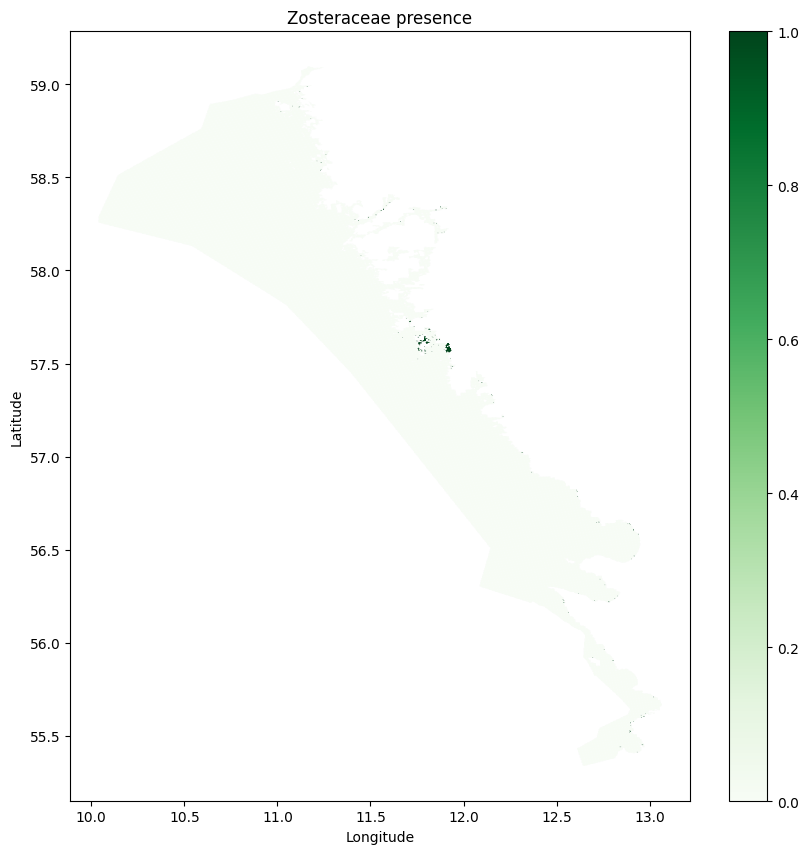

In [34]:
# Plot the result with the geometry
fig, ax = plt.subplots(figsize=(10, 10))
# Convert the DataFrame to a GeoDataFrame for plotting
df_inputs_variables["geometry"] = df_inputs_variables["geometry"].apply(wkt.loads)
gdf_plot = gpd.GeoDataFrame(df_inputs_variables, geometry="geometry", crs="EPSG:3006")
gdf_plot.plot(column="presence", ax=ax, legend=True, cmap="Greens")
plt.title("Zosteraceae presence")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

This is a map of the input data, showing the presence of Zosteraceae across the 250m x 250m grid. The green cells indicates the presence of Zoseraceae.

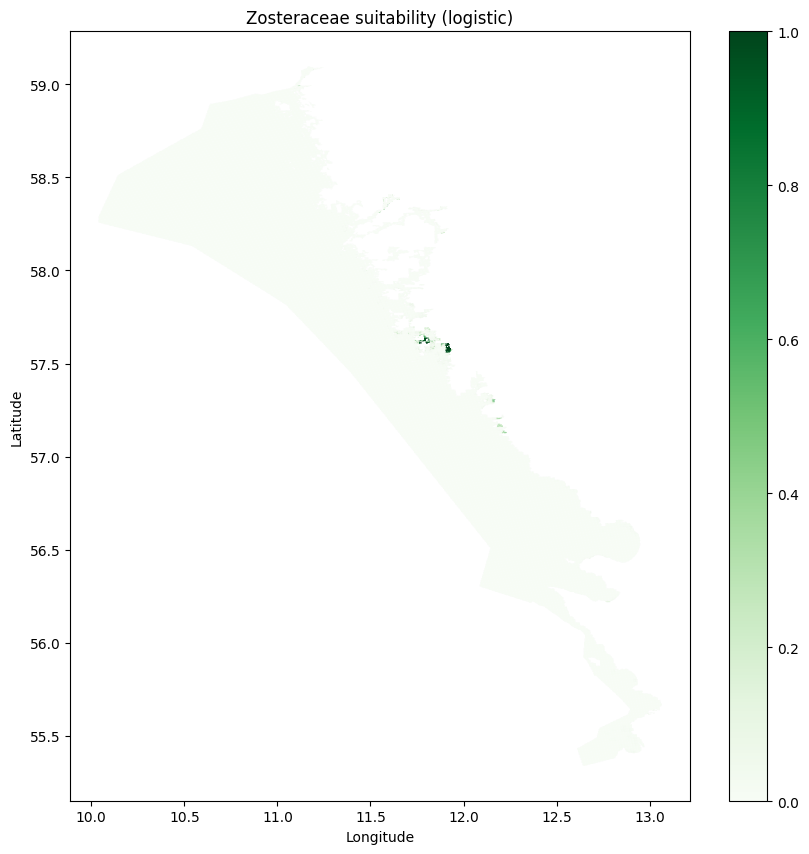

In [35]:
# Plot the result with the geometry
fig, ax = plt.subplots(figsize=(10, 10))
# Convert the DataFrame to a GeoDataFrame for plotting
# df_inputs_variables["geometry"] = df_inputs_variables["geometry"].apply(wkt.loads)
gdf_plot = gpd.GeoDataFrame(df_inputs_variables, geometry="geometry", crs="EPSG:3006")
gdf_plot.plot(column="suitability_logistic", ax=ax, legend=True, cmap="Greens")
plt.title("Zosteraceae suitability (logistic)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


This map shows the predicted probability of Zosteraceae presence across the 250m x 250m grid. The darker the green, the higher the probability of Zosteraceae presence. This visualization helps identify areas with high probabilities of Zosteraceae presence.

In [36]:
# Calculate the total area of the species presence (number of cells * 250 m²)
total_area = gdf_plot[gdf_plot["presence"] == 1].shape[0] * 250
print(f"Total area of Zosteraceae presence: {total_area} square meters")

# Calculate the total area of the species suitability (number of cells * 250 m²)
total_suitability_area = gdf_plot[gdf_plot["suitability_logistic"] > 0.5].shape[0] * 250
print(f"Total area of Zosteraceae suitability: {total_suitability_area} square meters")


Total area of Zosteraceae presence: 227750 square meters
Total area of Zosteraceae suitability: 197500 square meters


It seems strange that the predicted areas of Zosteraceae presence is smaller that the input data. 

### 💬 Comment

This model **needs to be evaluated and improved** using the ROC AUC and PR AUC as guidelines. 

The input data may not be sufficient. Many of the presence rows has been delated due to NaNs values in the environmental variables. The substrate type is not included in the model, which may be a significant factor in Zosteraceae presence. The model could also benefit from additional environmental variables.